In [48]:
%matplotlib inline
from matplotlib import style
style.use('bmh')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
# from scipy import stats

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine,inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect= True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [10]:
columns = inspector.get_columns('measurement')
for colunm in columns:
    primarykeystr = ""
    if colunm['primary_key'] == 1:
        primarykeystr = "Primary Key"
    print(colunm["name"], colunm["type"], primarykeystr)

id INTEGER Primary Key
station TEXT 
date TEXT 
prcp FLOAT 
tobs FLOAT 


In [11]:
columns = inspector.get_columns('station')
for colunm in columns:
    primarykeystr = ""
    if colunm['primary_key'] == 1:
        primarykeystr = "Primary Key"
    print(colunm["name"], colunm["type"], primarykeystr)

id INTEGER Primary Key
station TEXT 
name TEXT 
latitude FLOAT 
longitude FLOAT 
elevation FLOAT 


In [12]:
# Find the most recent date in the data set.
latest = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest

('2017-08-23',)

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
latestdate = dt.datetime.strptime(latest[0], '%Y-%m-%d' )
querydate = dt.date(latestdate.year -1, latestdate.month, latestdate.day)
sel = [Measurement.date, Measurement.prcp]
queryresult = session.query(*sel).filter(Measurement.date >= querydate).all()

In [37]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Rename the column
# Sort the dataframe by date
prcp_df = pd.DataFrame(queryresult, columns=['Date', 'Percipitation']).rename(columns={'Prcp':'Precipitation'})
prcp_final_df = prcp_df.set_index("Date")
prcp_final_df = prcp_final_df.sort_values(by='Date').dropna()
prcp_final_df.head()

,Percipitation
Date,
2016-08-23,0.0
2016-08-23,45.5
2016-08-23,1.3
2016-08-23,3.8
2016-08-23,17.8


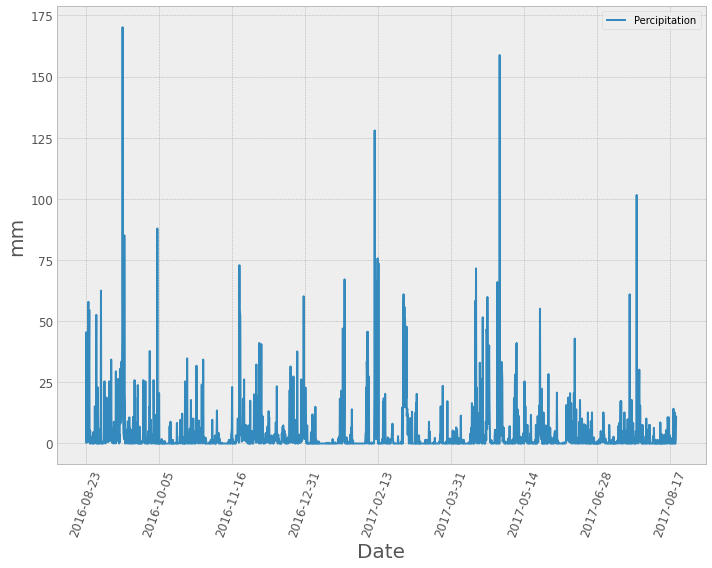

In [71]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_final_df.plot(figsize=(10,8))
plt.xticks(rotation=70,fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Date',fontsize=20)
plt.ylabel('mm',fontsize=20)
plt.tight_layout()
plt.savefig('Precipitation analysis.png')
plt.show()


In [39]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_final_df.describe()

,Percipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [40]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(Station.station).count()
total_stations

9

In [41]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    order_by(func.count(Measurement.station).desc()).\
    group_by(Measurement.station).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [54]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_number = 'USC00519281'
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == station_number).all()

[(12.2, 29.4, 22.03582251082252)]

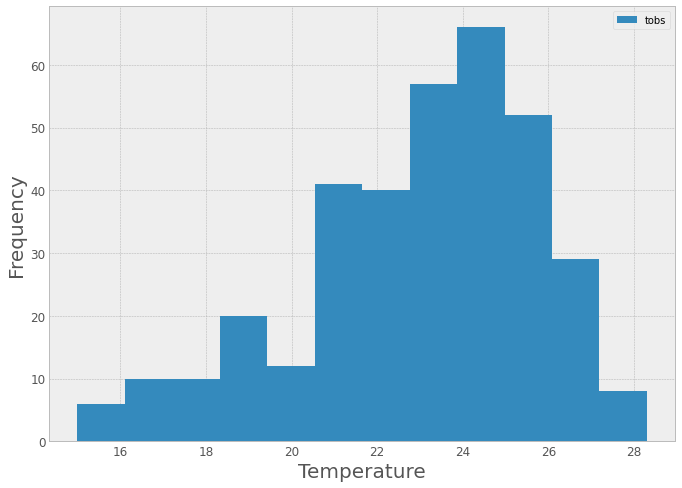

In [69]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_highest_temp = active_stations[0][0]

results = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= "2016-08-24").\
    filter(Measurement.date <= "2017-08-23").\
    filter(Measurement.station == station_highest_temp).all()

results_df = pd.DataFrame(results)

results_df.plot.hist(bins=12, figsize=(10,8))
plt.legend(['tobs'])
plt.xlabel('Temperature', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('station_plot.png')

# Close session

In [72]:
# Close Session
session.close()